In [1]:
%run setup_PS_data.ipynb
import pandas as pd

ERROR:root:File `'setup_notebook.ipynb.py'` not found.


Now loading mouse J048, run 27
This run has 2101 cells and 16117 frames
microcontroller trial starts occur on average -36.39 ms from galvo trial starts
number of pre frames: 21, number of post frames 21
Shape new array : (2101, 143, 42)
(2101, 143, 42) (2101, 8, 42)
photo stim occurences: {0: 51, 1: 51, 2: 41}
Occurence table:
[[26. 25.]
 [25. 26.]
 [ 5. 36.]]


In [2]:
nonnan_trials = np.unique(np.where(~np.isnan(behaviour_trials))[1])
behaviour_trials = behaviour_trials[:, nonnan_trials, :]
photostim = photostim[nonnan_trials]
decision = decision[nonnan_trials]
trial_subsets = trial_subsets[nonnan_trials]

print(behaviour_trials.shape)  # all trials  (n_neurons x n_trials x n_times)
print(photostim.shape)  # photostim (0=no PS; 1=5-50 stim; 2=150 stim)
print(decision.shape)  # decision (0=no go; 1=go)
print(np.unique(trial_subsets))  # exact amount of PS neurons
print(filter_ps_array)  # time points outside of laser artefact
final_pre_gap_tp = np.where(np.diff(filter_ps_array) > 1)[0][0]
print(final_pre_gap_tp)

(2101, 130, 42)
(130,)
(130,)
[  0   5  10  20  30  40  50 150]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
19


In [3]:
# stratified train test split
# train logistic reg
# evaluate soft-decision
# compare to trial_subsets

In [78]:
## Split data into train & test

include_150 = False  #NB: have not tried to implement this yet
trial_times_use = filter_ps_array[(final_pre_gap_tp + 1):(final_pre_gap_tp + 6)]
n_trial_times_used = len(trial_times_use)
neurons_include = np.arange(behaviour_trials.shape[0])
def fun_return_2d(data):  # fancy stuf
    return np.mean(data, 2)

if include_150 is False:
    trial_inds = np.where(photostim < 2)[0]
else:
    trial_inds = np.arange(len(photostim))
n_trials = len(trial_inds)
    
data_use = behaviour_trials[neurons_include, :, :]
data_use = data_use[:, :, trial_times_use]
data_use = data_use[:, trial_inds, :]
data_use = fun_return_2d(data_use)
stand_scale = sklearn.preprocessing.StandardScaler()
data_use = stand_scale.fit_transform(data_use)

sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=50, test_size=0.2)
dict_predictions_test ={x: np.array([]) for x in ['pred_stim_test', 'pred_dec_test',
                                                  'n_ps_test', 'dec_test']}
dict_predictions_train ={x: np.array([]) for x in ['pred_stim_train', 'pred_dec_train',
                                                  'n_ps_train', 'dec_train']}

i_loop = 0
for train_inds, test_inds in sss.split(X=np.zeros(n_trials), y=photostim[trial_inds]):
    pass

    train_data, test_data = data_use[:, train_inds], data_use[:, test_inds]
    if i_loop == 0:
        print(f'Shape train data {train_data.shape}, test data {test_data.shape}')

    train_labels = {'stim': photostim[trial_inds[train_inds]],
                    'dec': decision[trial_inds[train_inds]]}
    test_labels = {'stim': photostim[trial_inds[test_inds]],
                   'dec': decision[trial_inds[test_inds]]}
    detailed_ps_labels = trial_subsets[trial_inds]

    list_test = list(test_labels.keys())
    assert len(train_labels['dec']) == train_data.shape[1]
    assert len(test_labels['stim']) == test_data.shape[1]

    ## Train logistic regression model
    dec = {x: sklearn.linear_model.LogisticRegression(C=0.2).fit(
                X=train_data.transpose(), y=train_labels[x]) for x in list_test}

    pred_proba_train = {x: dec[x].predict_proba(X=train_data.transpose())[:, 1] for x in list_test}
    pred_proba_test = {x: dec[x].predict_proba(X=test_data.transpose())[:, 1] for x in list_test}

    for x in list_test:
        dict_predictions_train[f'pred_{x}_train'] = np.concatenate((dict_predictions_train[f'pred_{x}_train'], pred_proba_train[x]))
        dict_predictions_test[f'pred_{x}_test'] = np.concatenate((dict_predictions_test[f'pred_{x}_test'], pred_proba_test[x]))
    dict_predictions_train['n_ps_train'] = np.concatenate((dict_predictions_train['n_ps_train'], detailed_ps_labels[train_inds]))
    dict_predictions_test['n_ps_test'] = np.concatenate((dict_predictions_test['n_ps_test'], detailed_ps_labels[test_inds]))
    dict_predictions_train['dec_train'] = np.concatenate((dict_predictions_train['dec_train'], train_labels['dec']))
    dict_predictions_test['dec_test'] = np.concatenate((dict_predictions_test['dec_test'], test_labels['dec']))
    i_loop += 1
df_prediction_train = pd.DataFrame(dict_predictions_train)
df_prediction_test = pd.DataFrame(dict_predictions_test)

Shape train data (2101, 74), test data (2101, 19)


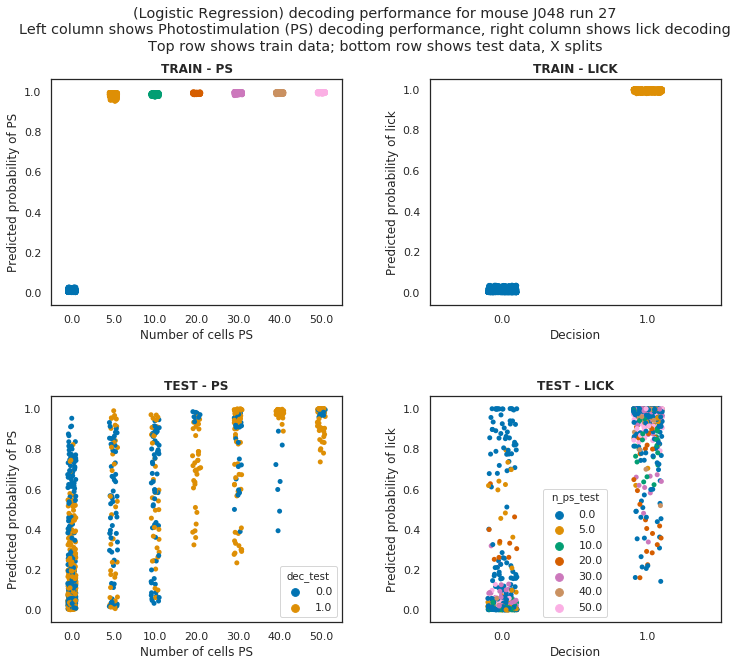

In [89]:



plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.subplot(221)
# sns.lineplot(x='n_ps_test', y='pred_stim_test', data=df_prediction_test)
sns.stripplot(x='n_ps_train', y='pred_stim_train', data=df_prediction_train)
plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')

plt.subplot(222)
sns.stripplot(x='dec_train', y='pred_dec_train', data=df_prediction_train)
plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')


plt.subplot(223)
sns.stripplot(x='n_ps_test', y='pred_stim_test', hue='dec_test', data=df_prediction_test)
plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')

plt.subplot(224)
sns.stripplot(x='dec_test', y='pred_dec_test', hue='n_ps_test', data=df_prediction_test)
plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');

plt.suptitle(f'(Logistic Regression) decoding performance for mouse {mouse} run {run_number}\n' + 
             f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
             f'Top row shows train data; bottom row shows test data, X splits\n');

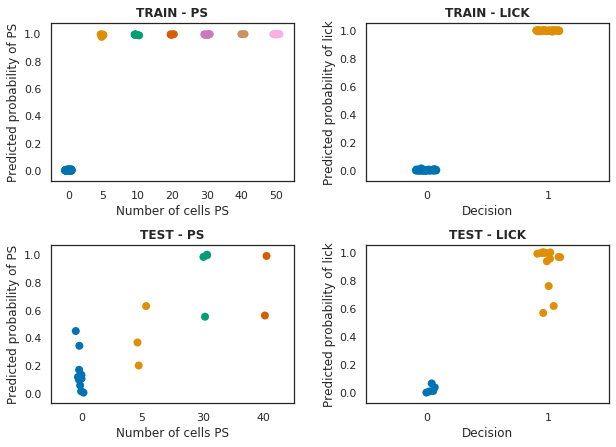

In [50]:

plt.rcParams['figure.figsize'] = (10, 7)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.subplot(221)
sns.stripplot(detailed_ps_labels[train_inds], pred_proba_train['stim'], size=8)
plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')

plt.subplot(222)
sns.stripplot(train_labels['dec'], pred_proba_train['dec'], size=8)
plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')


plt.subplot(223)
sns.stripplot(detailed_ps_labels[test_inds], pred_proba_test['stim'], size=8)
plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')

plt.subplot(224)
sns.stripplot(test_labels['dec'], pred_proba_test['dec'], size=8)
plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');

plt.suptitle('Single session')

## ideas to improve 

- Do DR on neurons first

- use all time points seperately (possibly combine with DR)

- Always compare to predict lick performance


